In [1]:
import numpy as np
import pandas as pd
import string
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet,stopwords
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.models import model_from_json
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle

nltk.download('stopwords')

Using TensorFlow backend.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lukky\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
data = pd.read_csv("bbc-text.csv")
data.head(10)

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
5,politics,howard hits back at mongrel jibe michael howar...
6,politics,blair prepares to name poll date tony blair is...
7,sport,henman hopes ended in dubai third seed tim hen...
8,sport,wilkinson fit to face edinburgh england captai...
9,entertainment,last star wars not for children the sixth an...


<function matplotlib.pyplot.show(*args, **kw)>

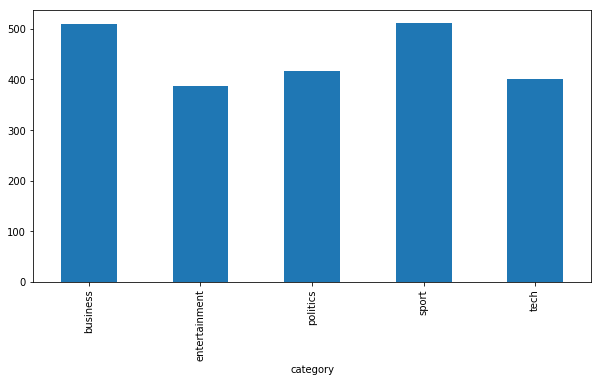

In [3]:
fig = plt.figure(figsize=(10,5))
data.groupby('category').text.count().plot.bar(ylim=0)
plt.show

In [4]:
label_dict={'business':0,'entertainment':1, 'politics':2, 'sport':3, 'tech':4}
inv_label_dict={0:'business',1:'entertainment', 2:'politics', 3:'sport', 4:'tech'}
label = []

for x in data['category']:
    label.append(label_dict[x])
    
print(label[:10])

text = data['text']
print(text[:10])

[4, 0, 3, 3, 1, 2, 2, 3, 3, 1]
0    tv future in the hands of viewers with home th...
1    worldcom boss  left books alone  former worldc...
2    tigers wary of farrell  gamble  leicester say ...
3    yeading face newcastle in fa cup premiership s...
4    ocean s twelve raids box office ocean s twelve...
5    howard hits back at mongrel jibe michael howar...
6    blair prepares to name poll date tony blair is...
7    henman hopes ended in dubai third seed tim hen...
8    wilkinson fit to face edinburgh england captai...
9    last star wars  not for children  the sixth an...
Name: text, dtype: object


In [5]:
def RemovePunctuation(sentence):
    return sentence.translate(str.maketrans("","", string.punctuation))

def stemming(sentence):
    tknzr = TweetTokenizer()
    line = tknzr.tokenize(sentence)
    stemmer = SnowballStemmer(language='english')
    s=""
    for i in range(len(line)):
        s =  s + " " + stemmer.stem(line[i])
    #print(np.asarray(s).reshape((1,1)))
    return s

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def lemmatizing(sentence):
    tknzr = TweetTokenizer()
    line = tknzr.tokenize(sentence)
    lemmatizer = WordNetLemmatizer()
    s=""
    for l in line:
        s+= " "+ lemmatizer.lemmatize(l, get_wordnet_pos(l))
    #lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(sentence)
    return s

def RemoveStopWords(sentence):
    stop_words = set(stopwords.words('english'))
    tknzr = TweetTokenizer()
    line = tknzr.tokenize(sentence)
    s=""
    for l in line:
        if l not in stop_words: 
            s+= " "+ l
    return s

In [6]:
stemmed_text=[]
for i in range(len(text)):
    s = RemovePunctuation(text[i])
    s = RemoveStopWords(s)
    s = stemming(s)
    stemmed_text.append( s )
    
for i in range(10):
    print(stemmed_text[i])

 tv futur hand viewer home theatr system plasma highdefinit tvs digit video record move live room way peopl watch tv radic differ five year time accord expert panel gather annual consum electron show las vega discuss new technolog impact one favourit pastim us lead trend programm content deliv viewer via home network cabl satellit telecom compani broadband servic provid front room portabl devic one talkedabout technolog ces digit person video record dvr pvr settop box like us tivo uk sky system allow peopl record store play paus forward wind tv programm want essenti technolog allow much personalis tv also builtin highdefinit tv set big busi japan us slower take europ lack highdefinit program peopl forward wind advert also forget abid network channel schedul put togeth alacart entertain us network cabl satellit compani worri mean term advertis revenu well brand ident viewer loyalti channel although us lead technolog moment also concern rais europ particular grow uptak servic like sky ha

In [7]:
max_ftr = 5000
tfidf_vector= TfidfVectorizer(sublinear_tf=True,     #to use a logarithmic form for frequency
                        min_df=5,              #minimum numbers of documents a word must be present in to be kept
                        norm='l2',             #to ensure all our feature vectors have a euclidian norm of 1
                        encoding='latin-1',  
                        ngram_range=(1, 2),    #to indicate that we want to consider both unigrams and bigrams
                        stop_words='english',  # to remove all common pronouns
                        max_features=max_ftr
                             )
tfidf_ = tfidf_vector.fit(stemmed_text)
print(tfidf_)
x_tfidf = tfidf_vector.transform(stemmed_text).toarray()

print( x_tfidf.shape )
print( type(x_tfidf) )

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='latin-1', input='content',
        lowercase=True, max_df=1.0, max_features=5000, min_df=5,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=True,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)
(2225, 5000)
<class 'numpy.ndarray'>


In [8]:
X = np.array(x_tfidf)
Y = np.array(label)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
print(Y_train[:5])
print(X_train.shape)
print(Y_train.shape)

[2 3 4 0 2]
(1490, 5000)
(1490,)


In [ ]:
clf_NB = MultinomialNB()
clf_NB.fit(X_train,Y_train)

y_pred = clf_NB.predict( X_train )
print("Train Accuracy with TfidfVectorizer with NaiveBayes Classifier: ",accuracy_score(y_true=Y_train, y_pred=y_pred))
y_pred = clf_NB.predict( X_test )
print("Test Accuracy with TfidfVectorizer with NaiveBayes Classifier: ",accuracy_score(y_true=Y_test, y_pred=y_pred))

In [ ]:
clf_SGD = linear_model.SGDClassifier(max_iter=5,alpha=1e-5,penalty ='l2',tol=1e-3)
clf_SGD.fit(X_train,Y_train)

y_pred = clf_SGD.predict( X_train )
print("Train Accuracy with TfidfVectorizer with SGD Classifier: ",accuracy_score(y_true=Y_train, y_pred=y_pred))
y_pred = clf_SGD.predict( X_test )
print("Test Accuracy with TfidfVectorizer with SGD Classifier: ",accuracy_score(y_true=Y_test, y_pred=y_pred))

In [ ]:
clf_NN = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(25, 10,5), random_state=1)
clf_NN.fit(X_train,Y_train)

y_pred = clf_NN.predict( X_train )
print("Train Accuracy with TfidfVectorizer with NN Classifier: ",accuracy_score(y_true=Y_train, y_pred=y_pred))
y_pred = clf_NN.predict( X_test )
print("Test Accuracy with TfidfVectorizer with NN Classifier: ",accuracy_score(y_true=Y_test, y_pred=y_pred))

In [ ]:
clf_NN=[None]*20
for i in range(1,19):
    print(i)
    clf_NN[i] = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(25, i,5), random_state=1)
    clf_NN[i].fit(X_train,Y_train)
    y_pred = clf_NN[i].predict( X_train )
    print(y_pred[:30])
    print(Y_train[:30])
    print("Train Accuracy with TfidfVectorizer with NN Classifier: ",accuracy_score(y_true=Y_train, y_pred=y_pred))
    y_pred = clf_NN[i].predict( X_test )
    print(y_pred[:30])
    print(Y_test[:30])
    print("Test Accuracy with TfidfVectorizer with NN Classifier: ",accuracy_score(y_true=Y_test, y_pred=y_pred))

In [9]:
#Changing labels from numbers to array
#Ex: 1-> 0,1,0,0,0,0
#Ex: 5-> 0,0,0,0,0,1
newLabel = np.zeros((len(label),5))
for idx, val in enumerate(label):
    newLabel[idx][val] = 1

Y = np.asarray(newLabel)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
print(Y_train[:5])
print(X_train.shape)
print(Y_train.shape)

[[0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]
(1490, 5000)
(1490, 5)


In [10]:
model = Sequential()
model.add(Dense(512, input_shape=(max_ftr,),activation='relu'))
model.add(Dense(5,activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [11]:
model.fit(X_train, Y_train, batch_size=100, epochs=5, verbose=1, validation_split=0.1)

Train on 1341 samples, validate on 149 samples
Epoch 1/5
1341/1341 [==============================] - 3s 2ms/step - loss: 1.3870 - acc: 0.7763 - val_loss: 0.9745 - val_acc: 0.9530
Epoch 2/5
1341/1341 [==============================] - 1s 756us/step - loss: 0.6529 - acc: 0.9814 - val_loss: 0.3903 - val_acc: 0.9933
Epoch 3/5
1341/1341 [==============================] - 1s 747us/step - loss: 0.2310 - acc: 0.9948 - val_loss: 0.1756 - val_acc: 0.9933
Epoch 4/5
1341/1341 [==============================] - 1s 765us/step - loss: 0.0911 - acc: 0.9970 - val_loss: 0.1086 - val_acc: 0.9933
Epoch 5/5
1341/1341 [==============================] - 1s 770us/step - loss: 0.0462 - acc: 0.9993 - val_loss: 0.0880 - val_acc: 0.9866


In [12]:
score = model.evaluate(X_test, Y_test, batch_size=100, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

735/735 [==============================] - 0s 136us/step
Test loss: 0.11584942275975026
Test accuracy: 0.9795918387620628


In [13]:
pred = model.predict(np.array([X_test[0]]))
print(np.argmax(pred))
print(np.argmax(Y_test[0]))

2
2


In [ ]:
txt = input()
txt = RemovePunctuation(RemoveStopWords(stemming(txt)))
txt = [txt]
txt = tfidf_vector.transform(txt).toarray()
print(txt.shape)

In [ ]:
pred = model.predict(txt)
print( inv_label_dict[np.argmax(pred)] )

In [15]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
model.save("Whole_model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
#loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
pred = loaded_model.predict(txt)
print( inv_label_dict[np.argmax(pred)] )

In [ ]:
pickle.dump(tfidf_, open("tfidf.pickle", "wb"))

In [ ]:
temp_tfidf = pickle.load(open("tfidf.pickle", 'rb'))
print(txt)
s = "lakshay singhla is amazon boi"
s = RemovePunctuation(RemoveStopWords(stemming(s)))
s = [s]
s = temp_tfidf.transform(s).toarray()
print(s)

In [ ]:
pred = loaded_model.predict(s)
print( inv_label_dict[np.argmax(pred)] )